## Message passing in GCN
A node in graph can send and recieve message from it connection (neighbors)
GCN can be seen as a simple message passing algorithm where the message is the feature vector
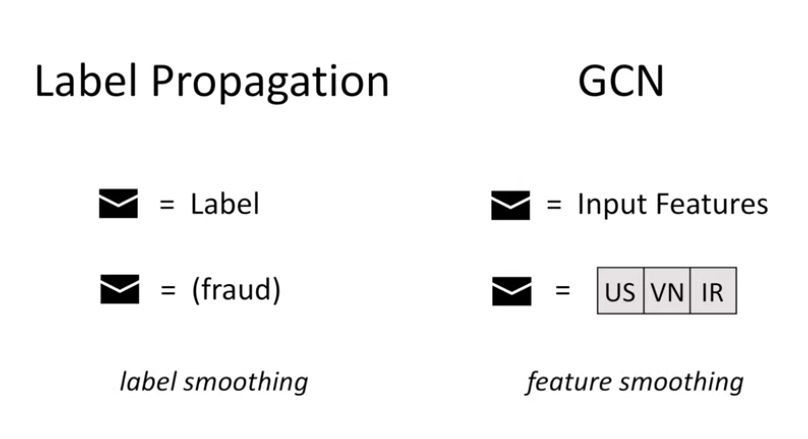

After the node can be seen as an averge (or any other aggregation) of its neighbors passed through non-linear function.
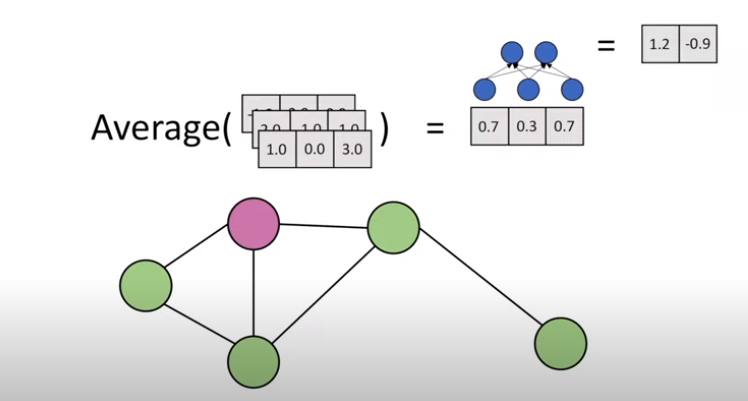
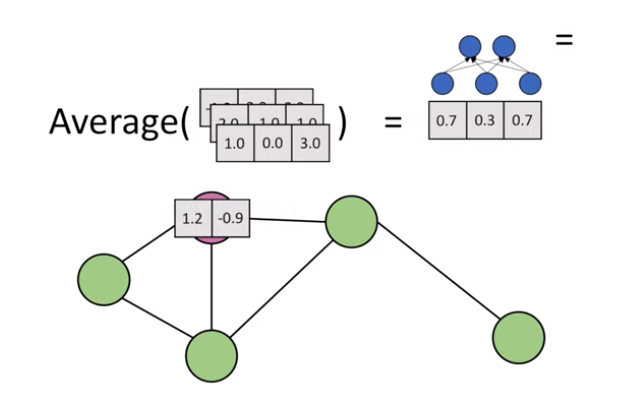

So this a nutshell about GCN
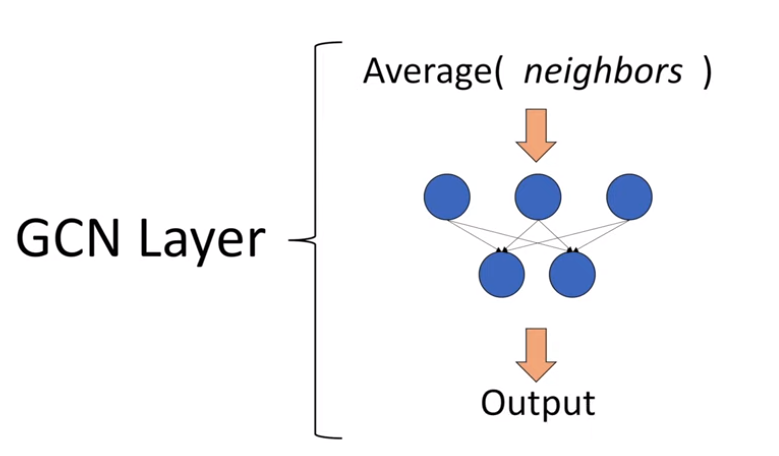
But what if we have two layer of GCN
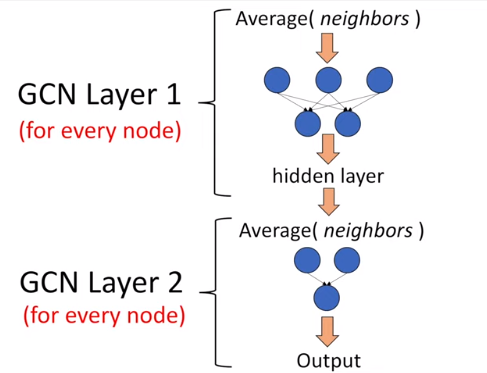


#### Relational Graph Convoution network (RGCN)
To apply GCN To a node:
1. Collect neighbors embeddings
2. Aggregate embeddings
3. Pass to NN ( multiply by W and apy activation function)

**Knowledge graph** can be thought of being built by triple (Source Node, Relation Type and Destination Node) 

It dosen't make sense to aggregate node that have different relation (for exp you can't aggreagete someone who blocked another on twitter with another follows him)

So, RGCN comes to solve this problem, a person follows another will have a specific Weight and a perso blocks another have another weight.

Chaque Weight est specifique au triple

##### Degree Matrix (au diagonal on a les nbr de voisin)

In [78]:
import numpy as np
import networkx as nx
import scipy.linalg as la
from scipy.special import softmax
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

In [128]:
# g = nx.karate_club_graph()
g = nx.binomial_tree(4)

In [129]:
g.number_of_nodes()

16

<function matplotlib.pyplot.show(close=None, block=None)>

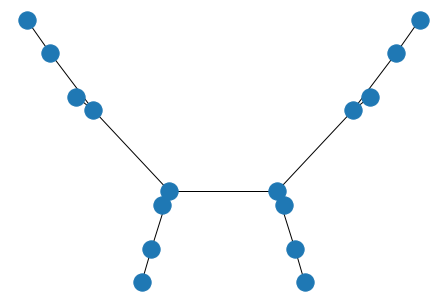

In [130]:
nx.draw_spectral(g)
plt.show

In [131]:
# Adjacent Matrix
A = np.array(nx.to_numpy_matrix(g))
A

array([[0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [132]:
# To create Laplacien Matrix
degree_of_nodes = np.count_nonzero(A, axis=1)
D = np.diag(degree_of_nodes)
D_inv_sqrt = np.linalg.inv(la.sqrtm(D))

Id = np.identity(g.number_of_nodes())

A_Laplacien = Id - np.dot(D_inv_sqrt, np.dot(A, D_inv_sqrt))

A_Laplacien.shape

(16, 16)

In [133]:
# input feature (but we don't have any node feature so we assign a vector containe one for each node)
X = np.identity(g.number_of_nodes())
def bias(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

In [134]:
    # GCN layer
    class GCN_Layer():
        def __init__(self, nbr_int, nbr_out, activation=None):
            self.nbr_int=nbr_int
            self.nbr_out=nbr_out
            # bias term
            self.W = bias(self.nbr_out, self.nbr_int)
            self.activation=activation
        def forward(self, A, X, W=None):
            """ An implementation of forward propagation 
                H=activation(W.A.H) 
                where: 
                H is the coming feat vect (intial layer it equal to X)
                W is learnable Weights
                Return a hidden layer output (H)
            """
            # initialization 
            # GCN Layer Forward
            self._A = A
            self._X = np.dot(A, X).T
            if W is None:
                W = self.W
                print("BBBBBBBBBBBBB")
                print(W.shape)
    #         W = W.T
            print("Shape of W in Forward GCN LAYER")
            print(W.shape)
            print("Shape of X in Forward GCN LAYER")
            print(self._X.shape)
            H = np.dot(W, self._X)
            if self.activation is not None:
                H = self.activation(H)
            self._H = H
            return self._H.T



        def backward(self, optim, update = True):
            d_th = 1 - np.asarray(self._H.T)**2
            d2 = np.multiply(optim.out, d_th)

            self.grad = np.dot(self._A, np.dot(d2, self.W))
            optim.out = self.grad

            dW = np.asarray(np.dot(d2.T, self._X.T))/ optim.bs
            dW_wd = self.W * optim.w / optim.bs

            if update:
                self.W -= (dW + dW_wd) * optim.alpha

            return dW + dW_wd


    # a dense layer
    class Softmax_Layer():
        def __init__(self, nbr_in, nbr_out):
            self.nbr_in = nbr_in
            self.nbr_out = nbr_out
            self.W = bias(self.nbr_out, self.nbr_in)
            self.b = np.zeros((self.nbr_out, 1))
            self._X = None # Used to calculate gradients


        def forward(self, X, W=None, b=None):

            # Softmax forward
            self._X = X.T
            print("Softmax input Shape")
            print(self._X.shape)
            if W is None:
                W = self.W
                print("Softmax W shape")
                print(W.shape)
            if b is None:
                b = self.b
                print("Softmax bias shape")
                print(b.shape)

            proj = np.asarray(np.dot(W, self._X))+b
            return softmax(proj).T

        def backward(self, optim, update=True):
            train_mask = np.zeros(optim.y_pred.shape[0])
            train_mask = [optim.train_nodes] = 1
            train_mask = train_mask.reshape((-1,1))

            # le derivé du Cost funtion
            d1 = asarray(optim.y_pred - optim.y_true)
            d1 = np.multiply(d1, train_mask)

            self.grad = np.dot(d1, self.W)
            optim.out = self.grad

            dW = np.dot(d1.T,self._X.T) / optim.bs
            db  = d1.T.sum(axis = 1, deepdims=True)/ optim.bs

            dW_ws = self.W * optim.wd / optim.bs

            if update:
                self.w -= (dW + dW_wd) * optim.lr
                self.b -= (db.reshape(self.b.shape) * optim.lr)


            return dW + dW_wd, db.reshape(self.b.shape)

    # Optimizer (Here I have used a simple gradient descent)

    class Gradient_Descent_Optimize():
        def __init__(self, alpha, w):
            self.alpha = alpha
            self.w = w
            self._y_pred = None
            self._y_true = None
            self._out = None
            self.bs = None
            self.train_nodes = None
        # to check the difference between call and init i Python
        # https://stackoverflow.com/questions/9663562/what-is-the-difference-between-init-and-call
        # The main that call method is used to make class as a funtion

        def __call__(self, y_pred, y_true, train_nodes=None):
            self.y_pred = y_pred
            self.y_true = y_true

            if self.train_nodes is None:
                self.train_nodes = np.arange(y_pred.shape[0])
            else:
                self.train_nodes = train_nodes

            self.bs = self.train_nodes.shape[0]

        @property
        def out(self):
            return self._out

        @out.setter
        def out(self, y):
            self._out = y



In [135]:
from networkx.algorithms.community import greedy_modularity_communities

# to regroup node using community algorithm
communities = greedy_modularity_communities(g)
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    print(i)
    print(list(com))
    colors[list(com)] = i
    print(len(list(com)))
    print(len(colors[list(com)]))

n_classes = len(communities)
# return the list of label (Id * [label value (0,1 or 2)] it return a list of [1,0,0] for label 0 and [0,1,0] for label 1 and [0,0,1 for label 2])
labels = np.eye(n_classes)[colors.astype(int)]

0
[0, 1, 2, 3]
4
4
1
[4, 5, 6, 7]
4
4
2
[8, 9, 10, 11]
4
4
3
[12, 13, 14, 15]
4
4


In [136]:

# for testing
gcn1 = GCN_Layer(g.number_of_nodes(), 2, activation=np.tanh)
sm1 = Softmax_Layer(2, n_classes)
opt = Gradient_Descent_Optimize(alpha=0, w=1.)

In [137]:
# for testing
gcn1_out = gcn1.forward(A_Laplacien, X)
opt(sm1.forward(gcn1_out), labels)


BBBBBBBBBBBBB
(2, 16)
Shape of W in Forward GCN LAYER
(2, 16)
Shape of X in Forward GCN LAYER
(16, 16)
Softmax input Shape
(2, 16)
Softmax W shape
(4, 2)
Softmax bias shape
(4, 1)


In [138]:
class GCN_Network():
    
    def __init__(self, nbr_int, nbr_out, nbr_layer, hidden_sizes, activation):
        self.nbr_int = nbr_int
        self.nbr_out = nbr_out
        self.nbr_layer = nbr_layer
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        
        self.layers = list()
        # The input layer
        gcn_in = GCN_Layer(nbr_int, hidden_sizes[0], activation)
        self.layers.append(gcn_in)
        
        # hidden layers
        for l in range(nbr_layer):
            gcn = GCN_Layer(self.layers[-1].W.shape[0], hidden_sizes[l])
            self.layers.append(gcn)
        
        # output layer 
        softmax_output = Softmax_Layer(hidden_sizes[-1], nbr_out)
        self.layers.append(softmax_output)
        
    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-1]:
            print(type(layer))
            H = layer.forward(A, H)
        return np.asarray(H)
    def forward(self, A, X):
        # GCN Layers
        H = self.embedding(A, X)
        
        # Softmax
        p = self.layers[-1].forward(H)
        
        return np.asarray(p)
        

In [139]:
gcn_model = GCN_Network(
    nbr_int=g.number_of_nodes(), 
    nbr_out=n_classes, 
    nbr_layer=2,
    hidden_sizes=[16, 2], 
    activation=np.tanh
)
gcn_model

In [140]:
y_pred = gcn_model.forward(A_Laplacien, X)
embed = gcn_model.embedding(A_Laplacien, X)
# xent(y_pred, labels).mean()

<class '__main__.GCN_Layer'>
BBBBBBBBBBBBB
(16, 16)
Shape of W in Forward GCN LAYER
(16, 16)
Shape of X in Forward GCN LAYER
(16, 16)
<class '__main__.GCN_Layer'>
BBBBBBBBBBBBB
(16, 16)
Shape of W in Forward GCN LAYER
(16, 16)
Shape of X in Forward GCN LAYER
(16, 16)
<class '__main__.GCN_Layer'>
BBBBBBBBBBBBB
(2, 16)
Shape of W in Forward GCN LAYER
(2, 16)
Shape of X in Forward GCN LAYER
(16, 16)
Softmax input Shape
(2, 16)
Softmax W shape
(4, 2)
Softmax bias shape
(4, 1)
<class '__main__.GCN_Layer'>
BBBBBBBBBBBBB
(16, 16)
Shape of W in Forward GCN LAYER
(16, 16)
Shape of X in Forward GCN LAYER
(16, 16)
<class '__main__.GCN_Layer'>
BBBBBBBBBBBBB
(16, 16)
Shape of W in Forward GCN LAYER
(16, 16)
Shape of X in Forward GCN LAYER
(16, 16)
<class '__main__.GCN_Layer'>
BBBBBBBBBBBBB
(2, 16)
Shape of W in Forward GCN LAYER
(2, 16)
Shape of X in Forward GCN LAYER
(16, 16)


In [50]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(g)
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    print(i)
#     print(list(com))
    colors[list(com)] = i
    print(len(list(com)))
    print(len(colors[list(com)]))

n_classes = len(communities)
# return the list of label (Id * [label value (0,1 or 2)] it return a list of [1,0,0] for label 0 and [0,1,0] for label 1 and [0,0,1 for label 2])
labels = np.eye(n_classes)[colors.astype(int)]

0
17
17
1
9
9
2
8
8


In [166]:
A = np.ones((42,2))
B = np.ones((2,42))
# Z = np.dot(A, B).T
Y = (A @ B).T
Y.shape

(42, 42)

In [167]:
b = np.array([[1,2,3],[0,0,0],[1,0,0]])

degree_of_nodes = np.count_nonzero(b, axis=1)
d = np.diag(degree_of_nodes)
d

array([[3, 0, 0],
       [0, 0, 0],
       [0, 0, 1]])

In [52]:
k = np.array([[4,9,25],[0,0,0],[1,0,0]])
from scipy.linalg import sqrtm
sqrtm(k).dot(sqrtm(k))

array([[4.00000000e+00+1.29939529e-16j, 9.00000000e+00+6.16844649e-16j,
        2.50000000e+01+1.31566753e-15j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j],
       [1.00000000e+00-1.29174937e-17j, 5.55111512e-16-6.03797794e-17j,
        4.44089210e-16+1.97020332e-16j]])